# <b>CS156 (Introduction to AI), Spring 2021</b>
# <u><b>Homework 9 submission</b></u>

### Roster Name: Neeval Kumar
### Preferred Name (if different): Chosen Name
### Student ID: 011877086
### Email address: kumar.neeval@gmail.com
Any special notes or anything you would like to communicate to me about this homework submission goes in here.

##  <u>References and sources </u>

List all your references and sources here.
This includes all sites/discussion boards/blogs/posts/etc. where you grabbed some code examples.

I only used tensorflows website for all the libraries. 

https://www.tensorflow.org/tutorials

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
np.random.seed(42)

#### Load images into keras datatset

In [3]:
image_size = (180, 180)
batch_size = 32

print("Preprocessing Training set: ")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers/training",
    labels='inferred', 
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,)

print("\nPreprocessing Validation set: ")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers/training",
    validation_split=0.2,
    labels='inferred', 
    label_mode='categorical',
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names

print("\nClass labels are: \n", class_names)

Preprocessing Training set: 
Found 3456 files belonging to 5 classes.
Using 2765 files for training.

Preprocessing Validation set: 
Found 3456 files belonging to 5 classes.
Using 691 files for validation.

Class labels are: 
 ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


#### Plot some images with their true labels

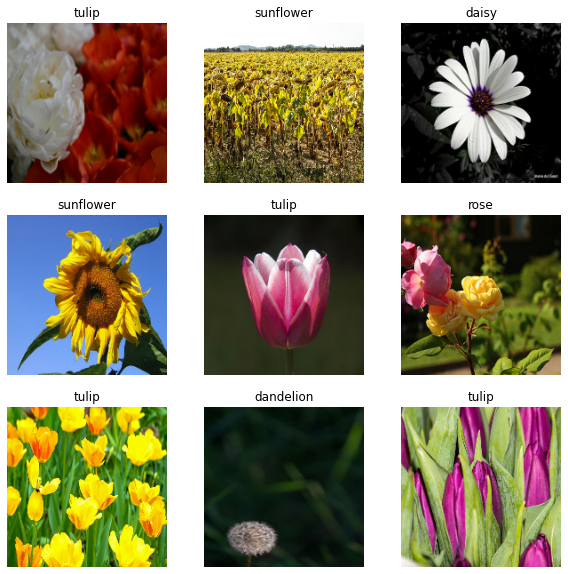

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        arr = labels[i].numpy()
        index_of = np.where(arr==1.)
        index_of = int(index_of[0])
        plt.title(class_names[index_of])
        plt.axis("off")


#### Augment Images and then plot augments

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

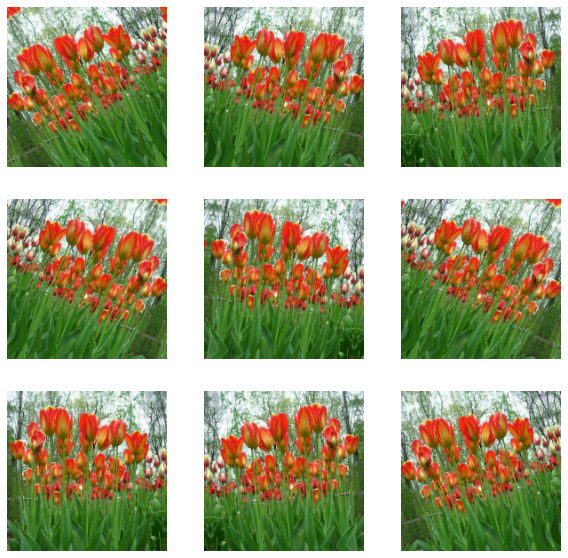

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### CNN that makes a model

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)



In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

#### Train Model

In [9]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
87/87 [==============================] - 356s 4s/step - loss: 1.3189 - accuracy: 0.4968 - val_loss: 1.7162 - val_accuracy: 0.2590
Epoch 2/20
87/87 [==============================] - 387s 4s/step - loss: 1.0320 - accuracy: 0.6204 - val_loss: 2.2801 - val_accuracy: 0.2590
Epoch 3/20
87/87 [==============================] - 341s 4s/step - loss: 0.9433 - accuracy: 0.6565 - val_loss: 3.1217 - val_accuracy: 0.2590
Epoch 4/20
87/87 [==============================] - 339s 4s/step - loss: 0.8775 - accuracy: 0.6830 - val_loss: 3.2253 - val_accuracy: 0.2590
Epoch 5/20
87/87 [==============================] - 6634s 77s/step - loss: 0.7986 - accuracy: 0.6966 - val_loss: 3.7676 - val_accuracy: 0.2590
Epoch 6/20
87/87 [==============================] - 4233s 49s/step - loss: 0.7009 - accuracy: 0.7308 - val_loss: 2.0200 - val_accuracy: 0.3415
Epoch 7/20
87/87 [==============================] - 361s 4s/step - loss: 0.7344 - accuracy: 0.7372 - val_loss: 1.0680 - val_accuracy: 0.6049
Epoch 8/2

#### Load Test Dataset

In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers/test",
    labels='inferred', 
    label_mode='categorical',
    seed=42,
    image_size=image_size,
    batch_size=1,
)
  

Found 861 files belonging to 5 classes.


#### Predict images from test set onto model, create lists for true labels and predicted labels. Also store 3 misclassified for visualization

In [11]:
true_labels = []
predicted_labels = []
misclassified = []
count = 0
for images, label in test_ds:
    predictions = model.predict(images)
    best_prediction = np.argmax(predictions)
    true_label = np.argmax(label)
    predicted_labels.append(best_prediction)
    true_labels.append(true_label) 
    
    if best_prediction != true_label and count != 3:
        misclass_arr = [label, images, best_prediction, true_label]
        misclassified.append(misclass_arr)
        count += 1

print("Finished test set onto model")

Finished test set onto model


#### Print Accuracy score of true labels and predicted labels, then plot confusion matrix

Accuracy score:  0.7073170731707317


Text(33.0, 0.5, 'True')

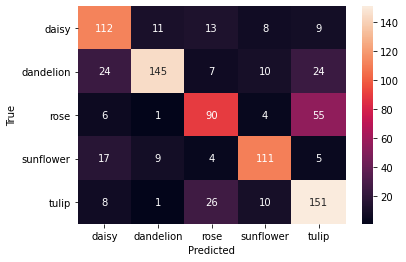

In [12]:
print("Accuracy score: ", accuracy_score(true_labels, predicted_labels))

cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy()
      
sns.heatmap(
    cm, annot=True,fmt = 'd',
    xticklabels=class_names,
    yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")

#### Display 3 misclassified Images

<Figure size 360x360 with 0 Axes>

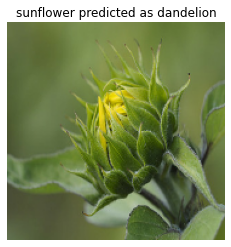

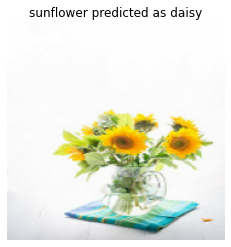

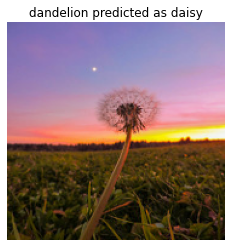

In [13]:

plt.figure(figsize=(5, 5))
for x in misclassified:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    label = x[0]
    new_image = x[1]
    img_title =  str(class_names[x[3]]) + " predicted as " + str(class_names[x[2]])
    plt.imshow(new_image[0].numpy().astype("uint8"))
    plt.title(img_title)
    plt.axis("off")
    